In [1]:
%load_ext autoreload
%autoreload 2

import cryogrid_data_fetcher as cdf

2024-09-06 13:17:53 | INFO     | Logger level changed to INFO


# Loading configuration

In [2]:
config = cdf.config.load('./requests/cryogrid_pamir_region.yml')

# cdf.config.make_template('./requests/cryogrid_template.yaml')

2024-09-06 13:17:53 | SUCCESS  | Loaded request from ./requests/cryogrid_pamir_region.yml
2024-09-06 13:17:53 | SUCCESS  | S3 bucket credentials found in environment variables


# Downloading elevation data from Planetary Computer

2024-09-06 12:51:37 | INFO     | Loading DEM from s3://spi-pamir-cryogrid/pamir/dem/DEM-cop-dem-glo-30-W7000_S3700_E7500_N4100.zarr


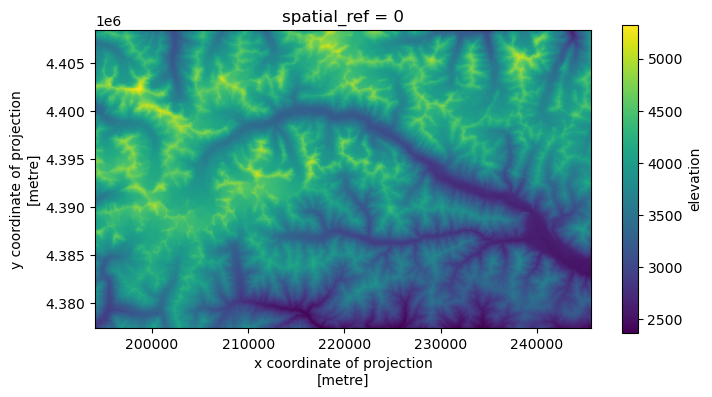

In [3]:
dem = cdf.download_dem_from_planetary_computer(config)
elev = dem.rio.clip_box(71.442442,39.509028,72.030211,39.770766, crs='EPSG:4326').elevation.compute()
img = elev.plot.imshow(size=4, aspect=2)
img.axes.set_aspect('equal', 'box')

# Downloading ERA5 data from WeatherBench repo

In [4]:
s3_flist = cdf.download_era5_from_weatherbench(config)

2024-09-06 12:51:45 | INFO     | File already exists: s3://spi-pamir-cryogrid/pamir/era5/raw/ERA5-CryoGrid_sub-W7000_S3700_E7500_N4100-geopotential.nc
2024-09-06 12:51:45 | INFO     | File already exists: s3://spi-pamir-cryogrid/pamir/era5/raw/ERA5-CryoGrid_sub-W7000_S3700_E7500_N4100-196001.nc
2024-09-06 12:51:45 | INFO     | File already exists: s3://spi-pamir-cryogrid/pamir/era5/raw/ERA5-CryoGrid_sub-W7000_S3700_E7500_N4100-196002.nc
2024-09-06 12:51:45 | INFO     | File already exists: s3://spi-pamir-cryogrid/pamir/era5/raw/ERA5-CryoGrid_sub-W7000_S3700_E7500_N4100-196003.nc
2024-09-06 12:51:45 | INFO     | File already exists: s3://spi-pamir-cryogrid/pamir/era5/raw/ERA5-CryoGrid_sub-W7000_S3700_E7500_N4100-196004.nc
2024-09-06 12:51:45 | INFO     | File already exists: s3://spi-pamir-cryogrid/pamir/era5/raw/ERA5-CryoGrid_sub-W7000_S3700_E7500_N4100-196005.nc
2024-09-06 12:51:45 | INFO     | File already exists: s3://spi-pamir-cryogrid/pamir/era5/raw/ERA5-CryoGrid_sub-W7000_S3700_E

# Formatting data for an experiment

In [93]:
fname_xls = '../cryogrid-pamir/abramov-simplest/abramov-simplest.xlsx'
cryogrid_xls = cdf.config.CryoExcel(fname_xls)

bbox = 71.481314,39.508578,72.000418,39.77
year_start, year_end = cryogrid_xls.get_start_end_times().dt.year

2024-09-06 13:44:29 | INFO     | Loaded CryoGrid Excel configuration file: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov-simplest/abramov-simplest.xlsx


### DEM

In [94]:
dem = cdf.download_dem_from_planetary_computer(config)
dem = dem.rio.clip_box(*bbox, crs='EPSG:4326')

dem.rio.to_raster(cryogrid_xls.fname.dem)

2024-09-06 13:44:33 | INFO     | Loading DEM from s3://spi-pamir-cryogrid/pamir/dem/DEM-cop-dem-glo-30-W7000_S3700_E7500_N4100.zarr


### Stratigraphy

In [12]:
ds_strat = (
    (dem * 0 + 1)
    .astype(int)
    .rename(elevation='stratigraphy')
    .assign_attrs(
        band='stratigraphy',
        platform='cryogrid-dummy',
        source='manual'))

ds_strat.attrs.pop("proj:epsg", None)
ds_strat.attrs.pop("proj:shape", None)

strat_fname = cryogrid_xls.get_class_filepath('READ_DATASET', index=1)
ds_strat.rio.to_raster(strat_fname)

### ERA5

In [99]:
s3_path = config.era5.dst_dir_s3 

cdf.era5.to_matlab.main(s3_path, cryogrid_xls.fname.era5, bbox_WSEN=bbox, year_start=year_start, year_end=year_end)

2024-09-06 13:49:00 | INFO     | File exists: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov-simplest/forcing/cryogrid-pamir_abramov-era5-1960_1990.nc
2024-09-06 13:49:02 | SUCCESS  | Saved ERA5 to /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov-simplest/forcing/cryogrid-pamir_abramov-era5-1960_1990.mat


PosixPath('/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov-simplest/forcing/cryogrid-pamir_abramov-era5-1960_1990.mat')